# 3i005 - projet 3 - 2019fev -

# ANALYSE DE SEQUENCES GENOMIQUES
L’objectif de ce projet est d’utiliser des méthodes d’analyse statistiques pour extraire de l’information des données génétiques. Un génome peut être vu en première approximation comme un suite de lettre (une sorte de livre), composé de différents éléments qui sont "lus" par la cellule pour lui permettre d’accomplir ses tâches. Nous verrons comment nous pouvons par l’analyse statistique de la séquence génomique (un texte) localiser ou détecter ces éléments.

## Prélude au projet

In [8]:
import pandas as pd # package for high-performance, easy-to-use data structures and data analysis
import numpy as np # fundamental package for scientific computing with Python

In [9]:
import projet as pj # our own code package to answer the different problematics

## Rappels de biologie
Les objets que nous étudions sont des génomes d’organismes vivant. En première approximation, un génome peut être vu comme une chaîne de caractère écrite dans un alphabet à 4 lettres (A,C,GouT). Depuis le début des années 90, il est devenu de plus en plus simple de <strong>séquencer</strong> un génome (le séquençage d’un génome humain coûte à  l’heure  actuelle  un  peu  moins  de  1000$).  Cependant  on  ne  peut  pas  comprendre, simplement à partir de la séquence génomique, comment cette information est utilisée par la cellule. C’est un peu comme avoir a disposition un manuel d’instructions écrit dans une langue inconnue. On doit donc <strong>décrypter</strong> un code pour comprendre le rôle des différents éléments qui sont présents le long de ce génome.<br/>
&nbsp;&nbsp;&nbsp;&nbsp;Dans la suite nous ne considérerons que des exemples sur des organismes unicellulaire, dont les génomes sont plus compactes et dont l’analyse statistique est plus simple.Comme première approximation, on peut distinguer deux types d’éléments d’intérêt le long des génomes, les <strong>gènes</strong> et les <strong>séquences promoteurs</strong>.

## Préliminaires: données et lecture de fichiers

In [10]:
sequence =pj.read_fasta("regulatory_seq_PHO.fasta")
nom = list(sequence.keys())
print(pj.code('TAC',3))
49//(4**2)
print(pj.inverse(49,3))
pj.genereMots(1)
pj.nucleotide_frequency(pj.simule_sequence(100000,[0.25,0.25,0.25,0.25]))
pj.probaempirique(sequence, 'ATATAT',1)

49
TAC


0.6

In [11]:
complet = []
for k in nom:
    complet = complet + sequence[k]
sequence["complet"] = complet
sequenceLength = pj.nucleotide_count(sequence["complet"])
letterFrequency = pj.nucleotide_frequency(sequence["complet"])
sequenceLog = pj.log_proba_sequence(nucleotide_frequency(sequence["complet"]))

In [12]:
pj.count_word(1, sequence[nom[0]])

{'T': 227, 'A': 255, 'C': 160, 'G': 158}

In [13]:
pj.comptage_attendu([0.25,0.25,0.49,0.01], 1, 100)

{'A': 25.0, 'C': 25.0, 'G': 49.0, 'T': 1.0}

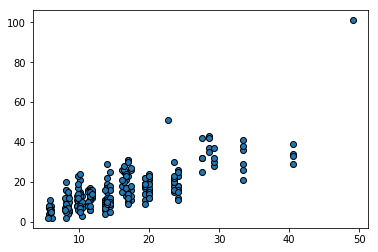

In [14]:
pj.graphique(4, sequence["complet"])
#On testera avec k = 2, 4, 6, 8.

In [15]:
mean = []
for i in range(1000):
    mean.append(pj.compare(4, pj.simule_sequence(100, [0.3, 0.01, 0.345, 0.345])))
np.mean([mean])

0.46931678269849686